In [1]:
import os,sys, operator
import shutil, gzip, math
import pickle
import numpy as np                                       # fast vectors and matrices
from glob import glob
from time import time
import matplotlib.pyplot as plt

import tensorflow as tf

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
from torch import tensor
from torch import nn
import torch.nn.functional as F

from pathlib import Path
from IPython.core.debugger import set_trace
from collections import Counter

%matplotlib inline

## Data Loader

In [3]:
train_feat_path="processed_dataset\\train\\feat\\"
train_label_path="processed_dataset\\train\\label\\"
test_feat_path="processed_dataset\\test\\feat\\"
test_label_path="processed_dataset\\test\\label\\"

train_name=os.listdir(train_feat_path)
test_name=os.listdir(test_feat_path)

class CustomTrainDataset(Dataset):
    def __init__(self, feat_path=train_feat_path , label_path=train_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

class CustomTestDataset(Dataset):
    def __init__(self, feat_path=test_feat_path , label_path=test_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        print(self.feat_path +self.img_labels[idx])
        return data, label
    
    def demo() :
        for indices in train :
            yield collate_fn(train_dataset[i] for i in indices)


In [4]:
train_dataset=CustomTrainDataset()
test_dataset=CustomTrainDataset()

## model

In [5]:
batch=32
nh = 88
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)
x,y = next(iter(train))

In [30]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        time= 1500
        batch = 32
        feat = [120, 118, 256, 88]
        lstm_unit = 128
        kernel_size=3
        nh=118
        self.layers = [ nn.Conv1d( 1500, 1500, kernel_size)]
        self.lstm =     nn.LSTM(input_size=feat[1], hidden_size=lstm_unit, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(feat[2],feat[3])
        print(self.layers)

    def __call__(self, x):
        for k in self.layers:
            torch.transpose(x, 0,1)
            x = k(x)
        
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

def normalize(x, m, s): 
    return (x-m)/s

class GetLSTMOutput(nn.Module):
        def forward(self, x):
            out, _ = x
            return out

In [31]:
x,y = next(iter(train))

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
xy =model(x)


TypeError: __init__() missing 1 required positional argument: 'kernel_size'

In [8]:
from sklearn.metrics import mean_squared_error
from torch import nn

loss = nn.MSELoss()

In [9]:
def M_accuracy(yhat, y):
    predictions = yhat.detach().numpy()
    true_values = y.detach().numpy()
    predictions = (predictions >=0.5) 
    correct = ((predictions >=0.5) == true_values)
    return correct.mean().item()

def M_loss_func(yhat,y):
    predictions = yhat
    true_values = y
    return loss(true_values, predictions)


## loop

In [10]:
from torch.utils.data import DataLoader
batch = 32
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)
epoch = len(train)

In [11]:
def get_epoch(k):
    print("epoch","\t loss \tacc")
    for i in range(0,k) :
        train_epoch()
        print(i,"\t",sum(losses[batch*i:batch*i + 1])/(batch),"\t",sum(metrics[batch*i:batch*i + 1])/batch)

def train_epoch():
    x,y =next(iter(train))
    for i in range(batch) :
        xb=x[i]
        yb=y[i]
        optimizer.zero_grad()

        yhatb = model(xb)
        loss = M_loss_func(yhatb, yb)
        acc = M_accuracy(yhatb, yb)    
        baseline_mse = nn.MSELoss()(torch.zeros_like(yb), yb)

        loss.backward()
        optimizer.step()
        
        losses.append(loss), metrics.append(acc), baseline.append(baseline_mse)

In [12]:
x,y =next(iter(train))
xb=x[0]
yb=y[0]
yhatb = model(xb)
baseline_mse = nn.MSELoss()(torch.zeros_like(yb), yb)
type(baseline_mse)

NameError: name 'model' is not defined

In [14]:
losses, metrics, baseline = [], [], []

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
get_epoch(5)
#torch.save(model.state_dict(), "weights/mymodel.pt")

[Conv1d(1500, 1500, kernel_size=(3,), stride=(1,))]
epoch 	 loss 	acc
0 	 tensor(0.0018, grad_fn=<DivBackward0>) 	 0.030189867424242425
1 	 tensor(0.0013, grad_fn=<DivBackward0>) 	 0.029935132575757577
2 	 tensor(0.0014, grad_fn=<DivBackward0>) 	 0.029799479166666667
3 	 tensor(0.0011, grad_fn=<DivBackward0>) 	 0.030155539772727273
4 	 tensor(0.0016, grad_fn=<DivBackward0>) 	 0.029498816287878787


In [25]:
temp_l, temp_acc=[],[]
for k in losses :
    temp_l.append(k.detach())


for k in metrics :
    temp_acc.append(k)



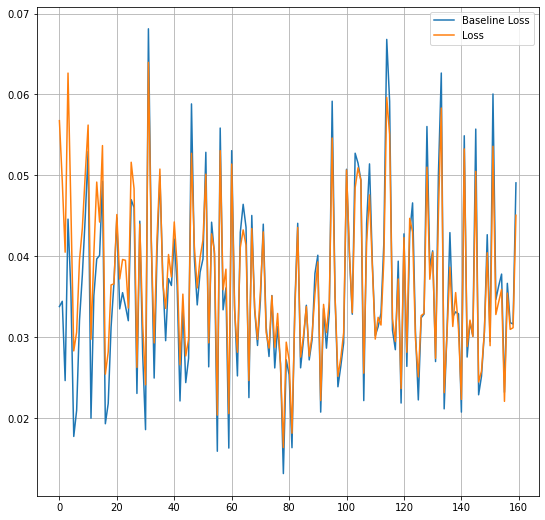

In [19]:
x = torch.arange(len(baseline)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.plot(x, baseline, label="Baseline Loss")
ax.plot(x, temp_l, label="Loss")
ax.grid(True)
ax.legend(loc='upper right')

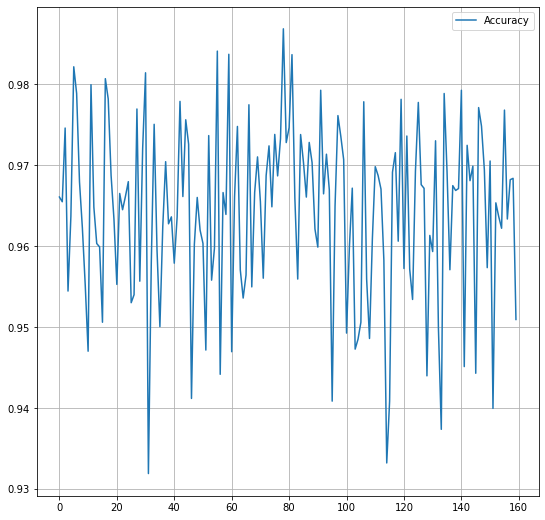

In [26]:
x = torch.arange(len(temp_acc)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, temp_acc, label="Accuracy")
ax.legend(loc='upper right')

In [17]:
#losses[-1], metrics[-1]
losses[-1], sum(y1)/len(y1)

NameError: name 'y1' is not defined

## TEST

In [ ]:
test = DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [ ]:
def get_test_epoch(k):
    for i in range(0,k) :
        test_epoch()

def test_epoch():
    x,y =next(iter(test))
    for i in range(batch) :
        for j in range(1500) :
            xb=x[i][j]
            yb=y[i][j]
            yhatb = model(xb)
            acc = M_accuracy(yhatb, yb)    
            metrics_test.append(acc)

In [ ]:
losses_test=[]
metrics_test=[]
get_test_epoch(5)

In [ ]:
sum(metrics_test)/len(metrics_test)

0.06989098544973546

In [ ]:
test_l, test_acc=[],[]
for k in losses :
    test_l.append(k.detach())

for k in metrics :
    test_acc.append(k)

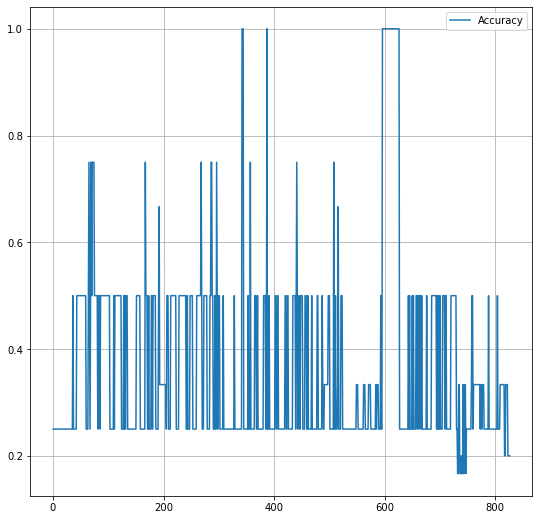

In [ ]:
y1=[item  for item in test_acc if (item>0)]

x = torch.arange(len(y1)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, y1, label="Accuracy")
ax.legend(loc='upper right')

In [ ]:
accuracy=M_accuracy(xy[0][0],y[0][0])
xy=(xy>=0.5).float()
correct = ((xy >=0.5) == y)

count = 4224000
count_t = (correct.float() == 1).sum()
count_f = (correct.float() == 0).sum()

accuracy , count_t/count, count_f/count

In [ ]:
xy[0][0], y[0][0]

In [ ]:
tx=xy.detach().numpy()
ty=y.detach().numpy()

In [ ]:
#วัดตัวที่ทายผิดใน epoch test

N=np.array([])
for i in range(batch) :
    for j in range(1500) :
        ct=0;
        for k in range(88) : 
            if(tx[i][j][k] != ty[i][j][k]) :
                ct+=1
        N=np.append(N,ct)

print(N.mean())


2.812666666666667


In [ ]:
#วัดตัวที่ทาย 1 เป็น 0 ใน epoch test
K=np.array([])
for i in range(batch) :
    for j in range(1500) :
        ct,CT =0,0;
        for k in range(88) : 
            if ty[i][j][k]==1 :
                CT+=1
                if(tx[i][j][k]==0) :
                    ct+=1
        if(CT==0) :
            if(ct==0) : K=np.append(K,0)
            else : K=np.append(K,ct)
        else : K=np.append(K,ct/CT)

print(K.mean())

0.927875
